In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import csv
import warnings

warnings.filterwarnings("ignore")

In [2]:
# read csv
df = pd.read_csv('historical_transaction.csv')

In [3]:
# preprocesses X_train
def preprocess_X_train(X_train):
    # convert x5 to float
    X_train['x5'] = X_train['x5'].str.replace('%', '').astype(float)
    
    # convert x57 to numeric
    X_train['x57'] = X_train['x57'].str.replace('$', '').astype(float)
    
    # use mode for categorical features and mean for non-categorical features to fill null values
    # store means and modes for all columns to use in test data
    means = {}
    modes = {}
    obj_columns = X_train.select_dtypes(include='object').columns
    for column in X_train.columns:
        if column in obj_columns:
            mode = X_train[column].mode()[0]
            X_train[column].fillna(mode, inplace=True)
            modes[column] = mode
        else:
            mean = X_train[column].mean()
            X_train[column].fillna(mean, inplace=True)
            means[column] = mean
        
    # convert x49 to binary
    X_train['x49'] = X_train['x49'].astype(bool).astype(int)
    
    # one-hot encode all categorical features
    obj_columns = X_train.select_dtypes(include='object').columns
    X_train = pd.get_dummies(data=X_train, columns=obj_columns)
    
    # normalize all features using min-max scaling
    scaler = MinMaxScaler()
    X_train_normalized = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    
    return X_train_normalized, means, modes

In [4]:
# preprocesses X_test
def preprocess_X_test(X_test, means, modes):
    # convert x5 to float
    X_test['x5'] = X_test['x5'].str.replace('%', '').astype(float)
    
    # convert x57 to numeric
    X_test['x57'] = X_test['x57'].str.replace('$', '').astype(float)
    
    # use means and modes from train data to fill null values
    obj_columns = X_test.select_dtypes(include='object').columns
    for column in X_test.columns:
        if column in obj_columns:
            X_test[column].fillna(modes[column], inplace=True)
        else:
            X_test[column].fillna(means[column], inplace=True)
        
    # convert x49 to binary
    X_test['x49'] = X_test['x49'].astype(bool).astype(int)
    
    # one-hot encode all categorical features
    obj_columns = X_test.select_dtypes(include='object').columns
    X_test = pd.get_dummies(data=X_test, columns=obj_columns)
    
    # normalize all features using min-max scaling
    scaler = MinMaxScaler()
    X_test_normalized = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)
    
    return X_test_normalized

In [5]:
# splits dataset into test and train and resamples train dataset
def split_preprocess_undersample_oversample_data(df, resample, undersample_ratio, oversample_ratio):
    X = df[df.columns[:-1]]
    y = df['y']
    
    # splitting data into train and test datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
    
    if resample:
        # preprocess X_train and X_test
        X_train_preprocessed, means, modes = preprocess_X_train(X_train)
        X_test_preprocessed = preprocess_X_test(X_test, means, modes)

        # add a column of 0s if a column is present in X_train but missing in X_test
        for column in X_train_preprocessed.columns:
            if column not in X_test_preprocessed.columns:
                X_test_preprocessed[column] = (np.zeros(len(X_test_preprocessed), )).astype(int)

        # add a column of 0s if a column is present in X_test but missing in X_train
        for column in X_test_preprocessed.columns:
            if column not in X_train_preprocessed.columns:
                X_train_preprocessed[column] = (np.zeros(len(X_train_preprocessed), )).astype(int)

        # make sure that features are in same order in X_train and X_test
        columns = X_train_preprocessed.columns.tolist()
        columns = sorted(columns)
        X_train_preprocessed = X_train_preprocessed[columns]
        X_test_preprocessed = X_test_preprocessed[columns]
        
        # implement undersampling on X_train
        random_undersample = RandomUnderSampler(sampling_strategy=undersample_ratio, random_state=0)
        X_train_preprocessed_undersampled, y_train_undersampled = random_undersample.fit_resample(X_train_preprocessed, y_train)

        # implement oversampling on X_train_undersampled_preprocessed
        adasyn_oversample = ADASYN(sampling_strategy=oversample_ratio, random_state=0)
        X_train_preprocessed_undersampled_oversampled, y_train_undersampled_oversampled = adasyn_oversample.fit_resample(X_train_preprocessed_undersampled, y_train_undersampled)
        
        return X_train_preprocessed_undersampled_oversampled, y_train_undersampled_oversampled, X_test_preprocessed, y_test
    
    else:
        # preprocess X_train and X_test
        X_train_preprocessed, means, modes = preprocess_X_train(X_train)
        X_test_preprocessed = preprocess_X_test(X_test, means, modes)

        # add a column of 0s if a column is present in X_train but missing in X_test
        for column in X_train_preprocessed.columns:
            if column not in X_test_preprocessed.columns:
                X_test_preprocessed[column] = (np.zeros(len(X_test_preprocessed), )).astype(int)

        # add a column of 0s if a column is present in X_test but missing in X_train
        for column in X_test_preprocessed.columns:
            if column not in X_train_preprocessed.columns:
                X_train_preprocessed[column] = (np.zeros(len(X_train_preprocessed), )).astype(int)

        # make sure that features are in same order in X_train and X_test
        columns = X_train_preprocessed.columns.tolist()
        columns = sorted(columns)
        X_train_preprocessed = X_train_preprocessed[columns]
        X_test_preprocessed = X_test_preprocessed[columns]
        
        return X_train_preprocessed, y_train, X_test_preprocessed, y_test

In [6]:
# define vairables to track highest recall score of minority class, best resampling ratio, and best model
highest_suspicious_recall = 0
best_resampling_ratio = None
resampled = False
best_model = None
best_X_train = None
best_y_train = None

# define accuracy threshold
accuracy_threshold = 0.9

In [7]:
# define models
svm = {'name' : 'svm', 'model' : SVC()}
rf = {'name' : 'random forest', 'model' : RandomForestClassifier()}
lr = {'name' : 'logistic regression', 'model' : LogisticRegression()}
knn = [{'name' : 'knn, k='+str(i+1), 'model' : KNeighborsClassifier(n_neighbors=i+1)} for i in range(5)]
model_dicts = [svm, rf, lr] + knn

In [8]:
# no resampling
for model_dict in model_dicts:
    model = model_dict['model']
    
    X_train, y_train, X_test, y_test = split_preprocess_undersample_oversample_data(df, False, 0, 0)
    model.fit(X_train, y_train)
    if model_dict['name'][:3] == 'knn':
        y_pred = model.predict(X_test.values)
    else:
        y_pred = model.predict(X_test)
        
    # track recall and accuracy
    recall = precision_recall_fscore_support(y_test, y_pred)[1][1]
    accuracy = accuracy_score(y_test, y_pred)
    
    # retain a model if it is better than current best model
    if accuracy >= accuracy_threshold and recall > highest_suspicious_recall:
        highest_suspicious_recall = recall
        best_model = model_dict
        best_X_train = X_train
        best_y_train = y_train

In [9]:
# different resampling ratios
for usr in [(10, 90), (15, 85), (20, 80), (25, 75)]:
    for osr in [(25, 75), (30, 70), (35, 65), (40, 60), (45, 55), (50, 50)]:
        if usr[0] < osr[0]:
            print('undersample_ratio:', usr)
            print('oversample_ratio:', osr)
            
            try:
                for model_dict in model_dicts:
                    model = model_dict['model']
                    
                    X_train, y_train, X_test, y_test = split_preprocess_undersample_oversample_data(df, True, usr[0]/usr[1], osr[0]/osr[1])
                    model.fit(X_train, y_train)
                    if model_dict['name'][:3] == 'knn':
                        y_pred = model.predict(X_test.values)
                    else:
                        y_pred = model.predict(X_test)
                        
                    # track recall and accuracy
                    recall = precision_recall_fscore_support(y_test, y_pred)[1][1]
                    accuracy = accuracy_score(y_test, y_pred)
                    
                    # retain a model if it is better than current best model
                    if accuracy >= accuracy_threshold and recall > highest_suspicious_recall:
                        highest_suspicious_recall = recall
                        best_resampling_ratio = (usr, osr)
                        best_model = model_dict
                        best_X_train = X_train    
                        best_y_train = y_train
                        if not resampled:
                            resampled = True
                print()
                        
            except:
                print('skipped')
                print()

undersample_ratio: (10, 90)
oversample_ratio: (25, 75)

undersample_ratio: (10, 90)
oversample_ratio: (30, 70)

undersample_ratio: (10, 90)
oversample_ratio: (35, 65)

undersample_ratio: (10, 90)
oversample_ratio: (40, 60)

undersample_ratio: (10, 90)
oversample_ratio: (45, 55)

undersample_ratio: (10, 90)
oversample_ratio: (50, 50)

undersample_ratio: (15, 85)
oversample_ratio: (25, 75)

undersample_ratio: (15, 85)
oversample_ratio: (30, 70)

undersample_ratio: (15, 85)
oversample_ratio: (35, 65)

undersample_ratio: (15, 85)
oversample_ratio: (40, 60)

undersample_ratio: (15, 85)
oversample_ratio: (45, 55)

undersample_ratio: (15, 85)
oversample_ratio: (50, 50)

undersample_ratio: (20, 80)
oversample_ratio: (25, 75)
skipped

undersample_ratio: (20, 80)
oversample_ratio: (30, 70)

undersample_ratio: (20, 80)
oversample_ratio: (35, 65)

undersample_ratio: (20, 80)
oversample_ratio: (40, 60)

undersample_ratio: (20, 80)
oversample_ratio: (45, 55)

undersample_ratio: (20, 80)
oversample_r

best resampling ratio: ((25, 75), (40, 60))
best model: random forest
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1512
           1       0.61      0.90      0.72        88

    accuracy                           0.96      1600
   macro avg       0.80      0.93      0.85      1600
weighted avg       0.97      0.96      0.97      1600

Log loss: 1.3516370020918933


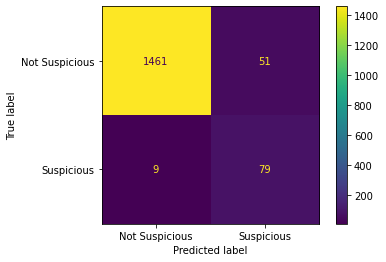

In [10]:
if resampled:
    print('best resampling ratio:', best_resampling_ratio)
else:
    print('no resampling')

print('best model:', best_model['name'])

if best_model['name'][:3] == 'knn':
    y_pred = best_model['model'].predict(X_test.values)
else:
    y_pred = best_model['model'].predict(X_test)

print(classification_report(y_test, y_pred))
print('Log loss:', log_loss(y_test, y_pred))

# display confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=["Not Suspicious", "Suspicious"])
cm_display.plot()
plt.show()

In [11]:
# preprocess current transactions data
current = pd.read_csv('current_transaction.csv')

# convert x5 to numeric
current['x5'] = current['x5'].str.replace('%', '').astype(float)

# convert x57 to numeric
current['x57'] = current['x57'].str.replace('$', '').astype(float)

# convert x5 and x7 to numeric in histoical dataframe
df['x5'] = df['x5'].str.replace('%', '').astype(float)
df['x57'] = df['x57'].str.replace('$', '').astype(float)

# use means and modes from historical data to fill null values
obj_columns = current.select_dtypes(include='object').columns
for column in current.columns:
    if column in obj_columns:
        historical_mode = df[column].mode()[0]
        current[column].fillna(historical_mode, inplace=True)
    else:
        historical_mean = df[column].mean()
        current[column].fillna(historical_mean, inplace=True)

# convert x49 to binary
current['x49'] = current['x49'].astype(bool).astype(int)

# one-hot encode all categorical features
obj_columns = current.select_dtypes(include='object').columns
current = pd.get_dummies(data=current, columns=obj_columns)

# normalize all features using min-max scaling
scaler = MinMaxScaler()
current_normalized = pd.DataFrame(scaler.fit_transform(current), columns=current.columns)

# add a column of 0s if a column is present in best_X_train but missing in current
for column in best_X_train.columns:
    if column not in current_normalized.columns:
        current_normalized[column] = (np.zeros(len(current_normalized), )).astype(int)

# add a column of 0s if a column is present in current but missing in best_X_train
for column in current_normalized.columns:
    if column not in best_X_train.columns:
        best_X_train[column] = (np.zeros(len(best_X_train), )).astype(int)
                
# make sure that features are in same order in best_X_train and current
columns = best_X_train.columns.tolist()
columns = sorted(columns)
best_X_train = best_X_train[columns]
current_normalized = current_normalized[columns]

In [12]:
# refit best_X_train to best model and make predictions for current transactions
best_model['model'].fit(best_X_train, best_y_train)
if best_model['name'][:3] == 'knn':
    y_pred = best_model['model'].predict(current_normalized.values)
else:
    y_pred = best_model['model'].predict(current_normalized)

# write predictions to predictions.csv
y_pred = [[pred] for pred in y_pred]
with open('predictions.csv', 'w', newline='') as out:
    writer = csv.writer(out)
    writer.writerow(['y'])
    writer.writerows(y_pred)

In [16]:
preds = pd.read_csv('predictions.csv')
preds['y'].value_counts()
# 93.5% seems about right

0    1870
1     130
Name: y, dtype: int64